In [10]:
import numpy as np
import pandas as pd 
import sys
import os 
import time
import random
import shap
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support

sys.path.append("../../")
from ACME.ACME import ACME 
sys.path.remove("../../")

np.random.seed(0)
random.seed(0)

# Time comparison between AcME-AD and KernelSHAP on Satellite
In this notebook we compute the time required by AcME-AD to compute explanations by respect to the time required by KernelSHAP, showing AcME-AD computational efficiency. 
We perform experiments on the Satellite Dataset.

We compare the times to explain different number of anomalies or by using various percentages of subsample of the background data for KernelSHAP or with different number of coalitions, as suggested in the official documentation (https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html). 

- fix size of background sample (entire dataset) and default number of coalitions: explain 20, 40, 60, 80, 100% of predicted anomalies 
- explain 10 anomalies by using random 25, 50 , 75 and 100 % samples of the dataset as background samples, with default number of coalitions
- explain 10 anomalies by using entire dataset and background sample by considering 25, 50, 75, 100 percentage of default number of coalitions. 

## Dataset 
Satellite dataset (https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite) is a classification dataset with 36 integer features, 6435 instances and 7 classes. To make it a anomaly detection dataset, we merge the training and test set and we mark the smallest classes, that is 2-4-5 as outliers, while the others as inliers. 

Class 1: 1533 samples | Class 2: 703 samples | Class 3: 1358 samples | Class 4: 626 samples | Class 5: 707 samples | Class 7: 1508 samples

In [2]:
with open("ad_datasets/satellite/sat.trn", "r") as f:
    data = f.readlines()
data = [x.strip().split() for x in data]
df = pd.DataFrame(data)

with open("ad_datasets/satellite/sat.tst", "r") as f:
    data = f.readlines()
data = [x.strip().split() for x in data]
df_test = pd.DataFrame(data)

data = pd.concat([df, df_test]).reset_index(drop=True)
data.rename(columns={36: "type"}, inplace=True)

# drop nan, replace empty strings with 0, convert to int 
data = data.replace("", 0)
data = data.astype(int)
data = data.dropna()

# classes 2-4-5 have "Target" = 1, else 0
data["Target"] = data["type"].apply(lambda x: 1 if x in [2, 4, 5] else 0)
features = data.columns[:-2]
display(data)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,type,Target
0,92,115,120,94,84,102,106,79,84,102,...,88,121,128,100,84,107,113,87,3,0
1,84,102,106,79,84,102,102,83,80,102,...,84,107,113,87,84,99,104,79,3,0
2,84,102,102,83,80,102,102,79,84,94,...,84,99,104,79,84,99,104,79,3,0
3,80,102,102,79,84,94,102,79,80,94,...,84,99,104,79,84,103,104,79,3,0
4,84,94,102,79,80,94,98,76,80,102,...,84,103,104,79,79,107,109,87,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,60,83,96,85,64,87,100,88,64,83,...,66,87,108,89,63,83,104,85,1,0
6431,64,79,100,85,56,71,96,85,56,68,...,66,83,100,85,63,83,100,81,1,0
6432,56,68,91,81,56,64,91,81,53,64,...,59,87,96,81,63,83,92,74,5,1
6433,56,68,87,74,60,71,91,81,60,64,...,59,83,92,74,59,83,92,70,5,1


## Training of Isolation Forest

In [3]:
def score_function(model, X): 
    return 0.5 * (-model.decision_function(X) + 1)

In [4]:
iforest = IsolationForest().fit(data[features])
data["Score"] = score_function(iforest, data[features])
data["Prediction"] = iforest.predict(data[features])
data["Prediction"] = data["Prediction"].apply(lambda x: 1 if x == -1 else 0)
precision, recall, f1, _ = precision_recall_fscore_support(data["Target"], data["Prediction"], average="binary")
print("Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(precision, recall, f1))

Precision: 0.825, Recall: 0.432, F1: 0.567


## Explanations

In [5]:
data_to_explain = data[data["Prediction"]==1].reset_index(drop=True)

In [6]:
def score_functions_shap(X): 
    return 0.5 * (iforest.decision_function(X) + 1)

### Explanations for different size of background dataset
Explain 10 anomalies using different sizes of backround dataset for KernelSHAP

In [ ]:
file_path = "results/shap_times_satellite_background.txt"

percentages = [0.25, 0.5, 0.75, 1]
reduced_datasets = [data.sample(frac=percentage, random_state=0) for percentage in percentages]
anomalies_back = data_to_explain.sample(n=10).reset_index(drop=True)

shap_background_times = []
for i in range(len(reduced_datasets)): 
    start_time = time.time()
    shap_explainer = shap.KernelExplainer(score_functions_shap, reduced_datasets[i][features].values)
    shap_exp = shap_explainer.shap_values(anomalies_back[features].values)
    stop_time = time.time()
    shap_background_times.append(stop_time - start_time)
    print("KernelSHAP {:d}: {:.3f} seconds".format(i, stop_time - start_time))
    with open(file_path, "a") as f: 
        f.write("KernelSHAP {:d}:: {:.3f} seconds\n".format(i, stop_time - start_time))

In [ ]:
# acme-ad for 10 anomalies 
start_time = time.time()
acme_exp = ACME(iforest, "Score", features, K=50, task="ad", score_function=score_function)
acme_exp = acme_exp.explain(data, True)
for i in range(len(anomalies_back)): 
    acme_loc = acme_exp.explain_local(anomalies_back.iloc[i])
    acme_loc.feature_importance(local=True)
stop_time = time.time()
print("ACME-AD: {:.3f} seconds".format(stop_time - start_time))
with open(file_path, "a") as f: 
    f.write("ACME-AD: {:.3f} seconds\n".format(stop_time - start_time))

### Explanations for different number of coalitions

In [ ]:
file_path = "results/shap_times_satellite_coalitions.txt"

percentages = [0.25, 0.5, 0.75, 1]
anomalies_coal = data_to_explain.sample(n=10).reset_index(drop=True)
K = 2*len(features) + 2048
coalitions = [int(K*percentage) for percentage in percentages]

shap_coalition_times = []
for i in range(len(coalitions)): 
    start_time = time.time()
    shap_explainer = shap.KernelExplainer(score_functions_shap, data[features].values)
    shap_exp = shap_explainer.shap_values(anomalies_coal[features].values, nsamples=coalitions[i])
    stop_time = time.time()
    shap_coalition_times.append(stop_time - start_time)
    print("KernelSHAP {:d}: {:.3f} seconds".format(i, stop_time - start_time))
    with open(file_path, "a") as f: 
        f.write("KernelSHAP {:d}: {:.3f} seconds\n".format(i, stop_time - start_time))

### Explanation for different numer of anomalies
We fix the size of the background sample as the complete dataset, we keep the default number of coalitions and we compute the time to explain the 0.2, 0.4, 0.6, 0.6 and 1.0 of the predicted anomalies. 

In [7]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
sampled_anomalies = [data_to_explain.sample(frac=percentage, random_state=0).reset_index(drop=True) for percentage in percentages]

# AcME-AD explantion times 
file_path = "results/acme_ad_times_satellite.txt"
acme_times = []
for i in range(len(sampled_anomalies)): 
    start_time = time.time()
    acme_exp = ACME(iforest, "Score", features, K=50, task="ad", score_function=score_function)
    acme_exp = acme_exp.explain(data, True)

    for idx in sampled_anomalies[i].index: 
        acme_loc = acme_exp.explain_local(sampled_anomalies[i].loc[idx])
        acme_loc.feature_importance(local=True)
    
    stop_time = time.time()
    acme_times.append(stop_time - start_time)
    print("AcME-AD {:d}: {:.3f} seconds".format(i, stop_time - start_time))
    with open(file_path, "a") as f: 
        f.write("AcME-AD {:d}: {:.3f} seconds\n".format(i, stop_time - start_time))

In [ ]:
# KernelSHAP explanation times 
shap_times = []
for i in range(len(sampled_anomalies)): 
    start_time = time.time()
    shap_explainer = shap.KernelExplainer(score_functions_shap, data[features].values)
    shap_exp = shap_explainer.shap_values(sampled_anomalies[i][features].values)
    stop_time = time.time()
    shap_times.append(stop_time - start_time)
    print("KernelSHAP {:d}: {:.3f} seconds".format(i, stop_time - start_time))
    with open(file_path, "a") as f: 
        f.write("KernelSHAP {:d}: {:.3f} seconds\n".format(i, stop_time - start_time))


#### Plot the time comparison

In [8]:
# # upload saved results
# acme_times, shap_times = [], []

# with open("results/acme_ad_times_satellite.txt", "r") as f:
#     lines = f.readlines()

# print(lines)

# for line in lines: 
#     method, time = line.strip().split(": ")
#     if "AcME-AD" in method: 
#         acme_times.append(float(time.split()[0]))
#     elif "KernelSHAP" in method:
#         shap_times.append(float(time.split()[0]))

['AcME-AD 0: 276.163 seconds\n', 'AcME-AD 1: 551.755 seconds\n', 'AcME-AD 2: 832.436 seconds\n', 'AcME-AD 3: 1126.952 seconds\n', 'AcME-AD 4: 1386.858 seconds\n', 'KernelSHAP 0: 13570.471 seconds\n', 'KernelSHAP 1: 27405.015 seconds\n', 'KernelSHAP 2: 40946.524 seconds\n', 'KernelSHAP 3: 57697.510 seconds\n', 'KernelSHAP 4: 69216.735 seconds\n']


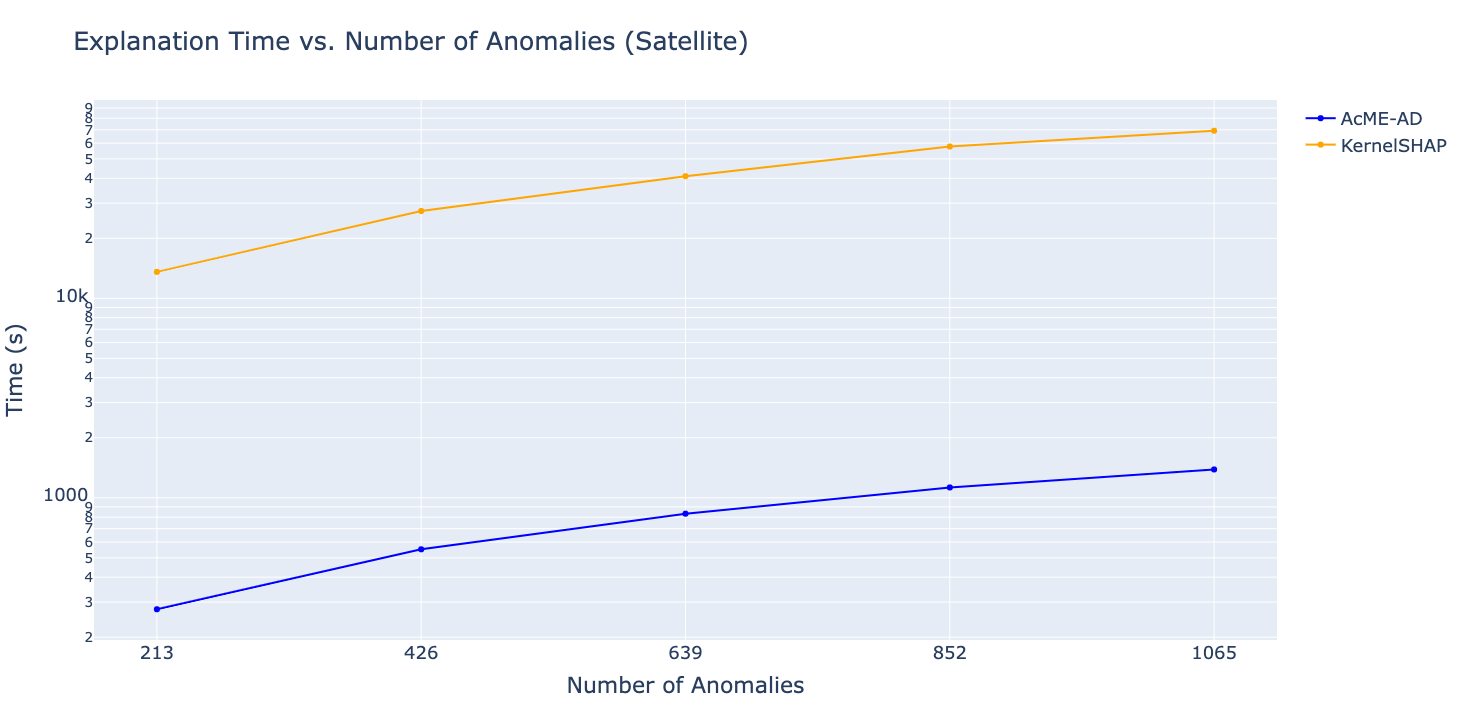

In [15]:
import plotly.graph_objects as go
n_sampled_anomalies = [len(x) for x in sampled_anomalies]

time_fig = go.Figure()
time_fig.add_trace(go.Scatter(
    x=n_sampled_anomalies, 
    y=acme_times, 
    mode="lines+markers", 
    name="AcME-AD", 
    line=dict(color="blue"), 
    marker=dict(color="blue")
))
time_fig.add_trace(go.Scatter(
    x=n_sampled_anomalies, 
    y=shap_times, 
    mode="lines+markers", 
    name="KernelSHAP", 
    line=dict(color="orange"), 
    marker=dict(color="orange")
))
time_fig.update_layout(
    title="Explanation Time vs. Number of Anomalies (Satellite)",
    xaxis_title="Number of Anomalies",
    yaxis_title="Time (s)",
    showlegend=True, 
    hovermode="x", 
    yaxis_type="log"
)
time_fig.update_xaxes(tickmode="array", tickvals=n_sampled_anomalies)
time_fig.update_layout(width = 10*1.2*100, height=6*1.2*100, font=dict(size=18))
time_fig.show()